In [ ]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import plot_histogram
# Updated to use SamplerV2, the latest primitive in qiskit-aer
from qiskit_aer.primitives import SamplerV2
import matplotlib.pyplot as plt

# Define a sample graph

In [ ]:
# A square graph with 4 nodes and 4 edges
n_nodes = 4
edges = [(0, 1), (1, 2), (2, 3), (3, 0)]
num_edges = len(edges)

# Define Quantum Oracle
Creates a simplified quantum oracle for the Max-Cut problem on a 4-node square graph.
This oracle is hardcoded to mark the two known optimal solutions ('0101' and '1010'), which both have a cut value of 4.
This avoids the complexity of building a general quantum adder and comparator.

In [ ]:
def create_simplified_maxcut_oracle(n):
    """
    Creates a simplified quantum oracle for the Max-Cut problem on a 4-node square graph.

    This oracle is hardcoded to mark the two known optimal solutions ('0101' and '1010'),
    which both have a cut value of 4. This avoids the complexity of building a
    general quantum adder and comparator.
    """
    # Quantum Registers
    qr_nodes = QuantumRegister(n, name='nodes')
    qr_output = QuantumRegister(1, name='output')

    # Create the oracle circuit
    oracle_circuit = QuantumCircuit(qr_nodes, qr_output, name='Oracle')

    # Mark the state '0101' (which is 1010 in Qiskit's little-endian bit order)
    oracle_circuit.x([qr_nodes[1], qr_nodes[3]])
    oracle_circuit.mcx(qr_nodes, qr_output)
    oracle_circuit.x([qr_nodes[1], qr_nodes[3]])
    oracle_circuit.barrier()

    # Mark the state '1010' (which is 0101 in Qiskit's little-endian bit order)
    oracle_circuit.x([qr_nodes[0], qr_nodes[2]])
    oracle_circuit.mcx(qr_nodes, qr_output)
    oracle_circuit.x([qr_nodes[0], qr_nodes[2]])

    return oracle_circuit

# Define check_grover_solution function
Runs Grover's algorithm with the given oracle and checks if a solution is found.
          

In [9]:
def check_grover_solution(n, oracle, num_solutions):

    # The static method `GroverOperator.optimal_num_iterations` is deprecated.
    # The calculation is now done manually.
    num_iterations = int(np.floor(np.pi / 4 * np.sqrt(2**n / num_solutions)))
    print(f"Calculated optimal number of Grover iterations: {num_iterations}")


    # Build the Grover operator
    grover_op = GroverOperator(oracle, insert_barriers=True)

    # Decompose the Grover operator into a circuit of basic gates that the simulator understands.
    decomposed_grover_op = grover_op.decompose()

    # Main circuit
    nodes_qubits = QuantumRegister(n, name='nodes')
    output_qubit = QuantumRegister(1, name='output')
    cr = ClassicalRegister(n, name="cr") # Named the classical register
    circuit = QuantumCircuit(nodes_qubits, output_qubit, cr)

    # Initial superposition for node qubits
    circuit.h(nodes_qubits)

    # Initialize output qubit to |-> state
    circuit.x(output_qubit)
    circuit.h(output_qubit)

    # Apply the DECOMPOSED Grover operator
    for _ in range(num_iterations):
        circuit.compose(decomposed_grover_op, inplace=True, qubits=nodes_qubits[:] + output_qubit[:])

    circuit.measure(nodes_qubits, cr)

    # Execute on the SamplerV2 (latest Qiskit 1.0 standard)
    sampler = SamplerV2()
    # SamplerV2 takes a list of circuits
    job = sampler.run([circuit], shots=1024)
    result = job.result()[0] # Get result for the first circuit

    # Get counts from the data field of the result
    counts = result.data.cr.get_counts()

    # Check if the desired solutions appear with high probability
    # Note: Qiskit's bit order is little-endian, so '0101' is measured for the '1010' partition.
    if '0101' in counts or '1010' in counts:
        if counts.get('0101', 0) > 50 or counts.get('1010', 0) > 50:
            return True, counts, circuit # Return the circuit as well

    return False, counts, circuit # Return the circuit as well

# Main Execution
As noted in the problem description, a full binary search requires a general,
parametric oracle (Cut(x) >= T), which is very complex to build.
We demonstrate one step of this process by searching for the optimal cut.

Running Grover's algorithm to find the Max-Cut...
Graph with 4 nodes and edges [(0, 1), (1, 2), (2, 3), (3, 0)]
Calculated optimal number of Grover iterations: 2

--- Results ---
Grover's algorithm successfully found one or more optimal cuts.
Best cut found (little-endian): 1000
Interpreted partition (x0,x1,x2,x3): 0001
Cut value (Max-Cut): 2

Measurement Histogram:


/tmp/ipython-input-5-1570419261.py:10: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op = GroverOperator(oracle, insert_barriers=True)


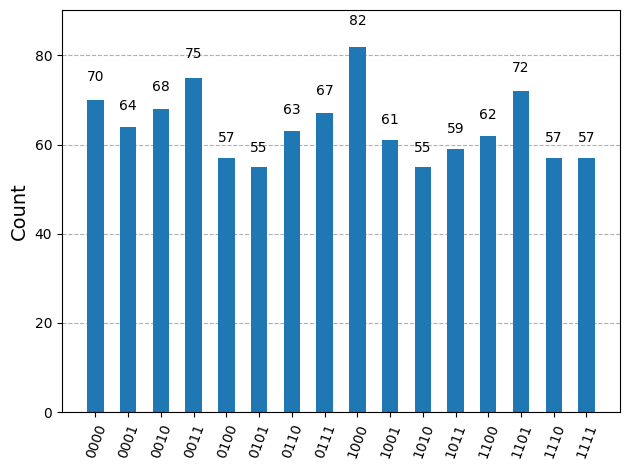

In [ ]:
print("Running Grover's algorithm to find the Max-Cut...")
print(f"Graph with {n_nodes} nodes and edges {edges}")

# We use the simplified oracle that directly searches for the optimal solution (Cut=4).
# This is equivalent to running one step of the binary search with T=4.
simplified_oracle = create_simplified_maxcut_oracle(n_nodes)

# We know there are 2 optimal solutions for this specific problem
num_known_solutions = 2
solution_found, final_counts = check_grover_solution(n_nodes, simplified_oracle, num_known_solutions)

print("\n--- Results ---")
if solution_found:
    print("Grover's algorithm successfully found one or more optimal cuts.")
    # Find the best cut from the results
    best_cut_str = max(final_counts, key=final_counts.get)

    def calculate_cut_value(partition_str, edge_list):
        cut_value = 0
        partition = partition_str[::-1]
        for u, v in edge_list:
            if partition[u] != partition[v]:
                cut_value += 1
        return cut_value

    max_cut_val = calculate_cut_value(best_cut_str, edges)

    print(f"Best cut found (little-endian): {best_cut_str}")
    print(f"Interpreted partition (x0,x1,x2,x3): {best_cut_str[::-1]}")
    print(f"Cut value (Max-Cut): {max_cut_val}")
else:
    print("The algorithm could not confidently find the optimal cut.")

# Display the results histogram
print("\nMeasurement Histogram:")
plot_histogram(final_counts)


# Plot the circuit

Oracle Circuit:


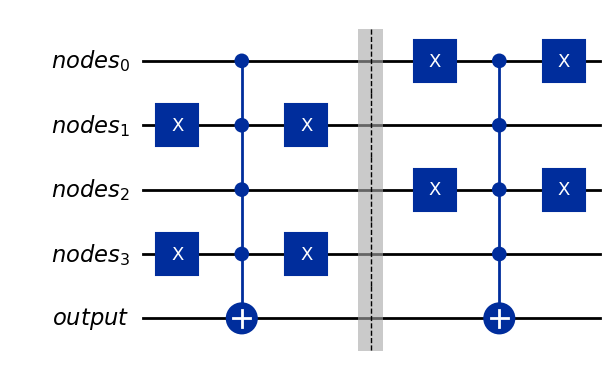

Calculated optimal number of Grover iterations: 2

Main Circuit:


/tmp/ipython-input-9-672841852.py:10: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op = GroverOperator(oracle, insert_barriers=True)


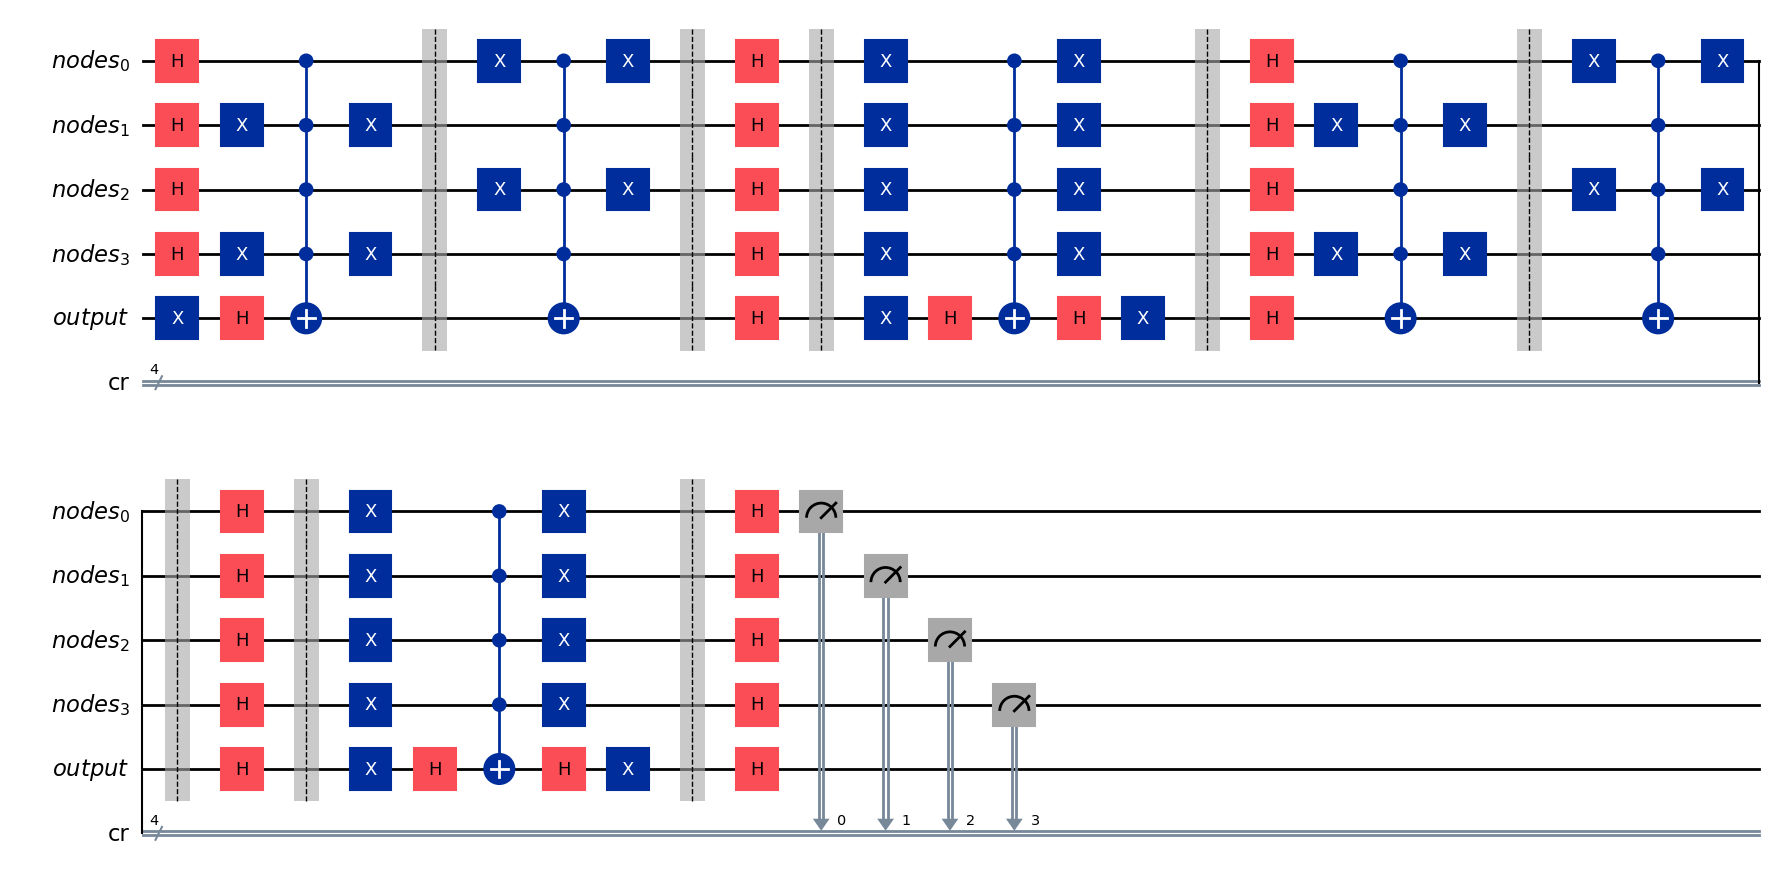

In [14]:
# Define the number of nodes
n_nodes = 4

# We use the simplified oracle that directly searches for the optimal solution (Cut=4).
# This is equivalent to running one step of the binary search with T=4.
simplified_oracle = create_simplified_maxcut_oracle(n_nodes)

# We know there are 2 optimal solutions for this specific problem
num_known_solutions = 2

print("Oracle Circuit:")
display(simplified_oracle.draw(output='mpl'))

# Re-run check_grover_solution to define 'circuit' in this scope
solution_found, final_counts, circuit = check_grover_solution(n_nodes, simplified_oracle, num_known_solutions)

print("\nMain Circuit:")
display(circuit.draw(output='mpl'))

